In [1]:
# ipynb形式のライブラリのインポート
%run ./lib.ipynb

In [2]:
# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 100)
# # ##### 各関数での実行時間を保存するためのCSVの空データを作成するための処理 #####
# # Processes = []
# # for i in range(1,16):
# #     Processes.append(i*i)
# # for j in range(9):
# #     Processes.append(2**j)
# # Processes = list(set(Processes))
# # Processes.sort()
# # index = classes
# # EmptyDF = pd.DataFrame(index=index, columns=Processes)
# # for benchmark in benchmarks:
# #     EmptyDF.to_csv(f"./csv_files/ExecTime@{benchmark}.csv")

# ##### 各ベンチマークの実行時間を記録する処理
# # # Benchmarks = []
# # # for benchmark in benchmarks:
# # #     Benchmarks.append(benchmark.upper())
# # # print(Benchmarks)

# # Processes = [8, 16, 32, 64, 128, 256]
# # for process in Processes:
# #     TimeDataList = return_TimeDataList(process)
# #     for DictData in TimeDataList:
# #         benchmark = DictData.benchmark
# #         process = DictData.process
# #         BenchmarkClass = DictData.BenchmarkClass
# #         time = DictData.time
# #         FillCSV(benchmark=benchmark, process=process, BenchmarkClass=BenchmarkClass, time=time)

# # # print(TimeDataList[0].return_AllData())




# # for benchmark in ['bt', 'mg', 'sp']:
# FixClass = "B"
# for benchmark in ['mg']:
#     print(f"benchmark={benchmark}")
#     TargetDF = return_FixedClassModelDF(benchmark=benchmark, FixClass=FixClass)
#     BestModelsInTargetDF = BestModelsInDF(TargetDF)
#     print(BestModelsInTargetDF)
#     TargetDF = return_ErrorRateFixedClassDFwithAverage(benchmark = benchmark , FixClass=FixClass)
#     print(TargetDF)

# # for benchmark in ['bt', 'mg', 'sp']:
# for benchmark in ['mg']:
#     ProcessExcludeBTSP = [1,2,4,8,16,32,64,128,256]
#     ProcessIncludeBTSP = [1, 4, 16, 64, 256]

#     TestRates = [0, 0.2, 0.4, 0.6, 0.8]
#     if(benchmark == "bt" or benchmark == "sp"):
#         processes=ProcessIncludeBTSP
#     else:
#         processes=ProcessExcludeBTSP
#     RawDataList = return_fixed_class(BenchMark=benchmark, Processes=processes,FixedBenchMarkClass=FixClass)
#     RawDataDF = pd.concat(RawDataList, axis=1)
#     print(RawDataDF)
# print('SET_CLASS' in RawDataDF.index.tolist())
# print(RawDataDF.loc['SET_CLASS'])

# for benchmark in benchmarks:
#     print(return_ErrorRateFixedProcess_AveragePredictCostRealCost(benchmark=benchmark, FixProcess=64, predict_class="D"))
#     print(return_ErrorRateFixedClass_AveragePredictCostRealCost(benchmark=benchmark, FixClass="B", predict_process=256))

# "SET_CLASS"に代表される関数が、プロファイル数が2個のときだけ突飛な平均誤差率を出力する。その原因は学主データ二個だと基本的に線形モデルを採用することになるが、そうすると、実際の最適モデルが反比例や対数だった場合に予測値と実測値が大幅にずれる。したがって、プロファイル数が2個のときにだけ突飛な平均誤差率を出力する。

# 実際に予測することになる関数のみだけを、表示するようにして、出力されるデータを見やすくする(↑の話)。

# 表のタイトルをそのまま保存時のファイル名にすればええんか

In [3]:
# # 問題サイズDに対する予測で、プロファイル数３の時の平均平均誤差率 < プロファイル数４の時の平均平均誤差率　となっているものを探す
# Fixed="Process"
# Fix=64
# FixProcess=Fix
# Predict="D"
# predict_class=Predict
# EnableTitle=False
# SaveGraph=False
# for benchmark in benchmarks:
#     ErrorRateFixedProcess = return_ErrorRateFixedProcessAverageAndCosts(benchmark=benchmark, FixProcess=FixProcess, predict_class=predict_class)
#     print(benchmark)
#     ErrorRateFixedProcess

# for benchmark in benchmarks:
#     print(f"FixProcess_{benchmark}")
#     FixProcessDF = return_summarized_Fixed_dataframe(BenchMark_name = benchmark, fixed="process")
#     FixProcessDFwithoutNaN = FixProcessDF.dropna(how='any', axis=0)
#     FixProcessDFwithoutNaN
#     indice = FixProcessDFwithoutNaN.T.index.tolist()
#     columns = FixProcessDFwithoutNaN.T.columns.tolist()
#     plt.figure()
#     x = indice
#     for column in columns:
#         y = FixProcessDFwithoutNaN.loc[column]
#         plt.plot(x, y, label=column)
#     plt.yscale('log')
#     plt.legend()
#     plt.show()

# for benchmark in benchmarks:
#     print(f"FixClass_{benchmark}")
#     FixClassDF = return_summarized_Fixed_dataframe(BenchMark_name = benchmark, fixed="class")
#     FixClassDFwithoutNaN = FixClassDF.dropna(how='any', axis=0)
#     FixClassDFwithoutNaN
#     indice = FixClassDFwithoutNaN.T.index.tolist()
#     columns = FixClassDFwithoutNaN.T.columns.tolist()
#     plt.figure()
#     x = indice
#     for column in columns:
#         y = FixClassDFwithoutNaN.loc[column]
#         plt.plot(x, y, label=column)
#     plt.yscale('log')
#     plt.legend()
#     plt.show()

## 以下記述移行予定

In [4]:
# # ベンチマークCGでプロセス数を固定したもの

# outputDF = 0
# for benchmark in ["cg"]:
#     print(f"FixProcess_{benchmark}")
#     FixProcessDF = return_summarized_Fixed_dataframe(BenchMark_name = benchmark, fixed="process")
#     FixProcessDFwithoutNaN = FixProcessDF.dropna(how='any', axis=0)
#     outputDF = FixProcessDFwithoutNaN
#     indice = FixProcessDFwithoutNaN.T.index.tolist()
#     columns = FixProcessDFwithoutNaN.T.columns.tolist()
#     plt.figure()
#     x = indice
#     for column in columns:
#         y = FixProcessDFwithoutNaN.loc[column]
#         plt.plot(x, y, label=column)
#     plt.yscale('log')
#     plt.legend()
#     plt.show()
# ICNVRTfixProcessDF = outputDF.loc["ICNVRT":"ICNVRT"]
# ICNVRTfixProcessDF

# # ベンチマークCGでベンチマーククラスを固定したもの

# outputDF = 0
# for benchmark in ["cg"]:
#     print(f"FixClass_{benchmark}")
#     FixClassDF = return_summarized_Fixed_dataframe(BenchMark_name = benchmark, fixed="class")
#     FixClassDFwithoutNaN = FixClassDF.dropna(how='any', axis=0)
#     outputDF = FixClassDFwithoutNaN
#     indice = FixClassDFwithoutNaN.T.index.tolist()
#     columns = FixClassDFwithoutNaN.T.columns.tolist()
#     plt.figure()
#     x = indice
#     for column in columns:
#         y = FixClassDFwithoutNaN.loc[column]
#         plt.plot(x, y, label=column)
#     plt.yscale('log')
#     plt.legend()
#     plt.show()
# ICNVRTfixClassDF = outputDF.loc["ICNVRT":"ICNVRT"]
# ICNVRTfixClassDF

# intList = ConvertBenchmarkClasses(ICNVRTfixProcessDF.columns.tolist())
# intList
# ICNVRTfixProcessDF.columns = intList
# ICNVRTfixProcessDF
# ICNVRTfixClassDF

fixProcess用入力

```
PARAMETER p
POINTS (1) (4) (16)

REGION example
METRIC time
DATA 180347 180347 180347
DATA 1706010.0 1706010.0 1706010.0
DATA 3936140.0 3936140.0 3936140.0
```

fixProcess用出力

```
Callpath: example
	Metric: time
		Measurement point: (1.00E+00) Mean: 1.80E+05 Median: 1.80E+05
		Measurement point: (4.00E+00) Mean: 1.71E+06 Median: 1.71E+06
		Measurement point: (1.60E+01) Mean: 3.94E+06 Median: 3.94E+06
		Model: -3590464.6990329633 + 3759195.349891038 * p^(1/4)
		RSS: 8.79E+09
		Adjusted R^2: 9.98E-01
```

fixClass用入力

```
PARAMETER p
POINTS (1) (2) (4) (8) (16) (32) (64) (128)

REGION example
METRIC time
DATA 1984770.0 1984770.0 1984770.0
DATA 2263540.0 2263540.0 2263540.0
DATA 2821070.0 2821070.0 2821070.0
DATA 3936140.0 3936140.0 3936140.0
DATA 3936140.0 3936140.0 3936140.0
DATA 3936140.0 3936140.0 3936140.0
DATA 3936140.0 3936140.0 3936140.0
DATA 3936140.0 3936140.0 3936140.0
```

fixClass用出力


```
Callpath: example
	Metric: time
		Measurement point: (1.00E+00) Mean: 1.98E+06 Median: 1.98E+06
		Measurement point: (2.00E+00) Mean: 2.26E+06 Median: 2.26E+06
		Measurement point: (4.00E+00) Mean: 2.82E+06 Median: 2.82E+06
		Measurement point: (8.00E+00) Mean: 3.94E+06 Median: 3.94E+06
		Measurement point: (1.60E+01) Mean: 3.94E+06 Median: 3.94E+06
		Measurement point: (3.20E+01) Mean: 3.94E+06 Median: 3.94E+06
		Measurement point: (6.40E+01) Mean: 3.94E+06 Median: 3.94E+06
		Measurement point: (1.28E+02) Mean: 3.94E+06 Median: 3.94E+06
		Model: 2286768.3333333326 + 301997.61904761934 * log2(p)^(1)
		RSS: 2.18E+12
		Adjusted R^2: 4.96E-01
```


<Figure size 2000x2000 with 0 Axes>

Text(0, 0.5, '関数コール回数')

Text(0.5, 0, '問題サイズ[A=1, B=4, C=16, D=256]')

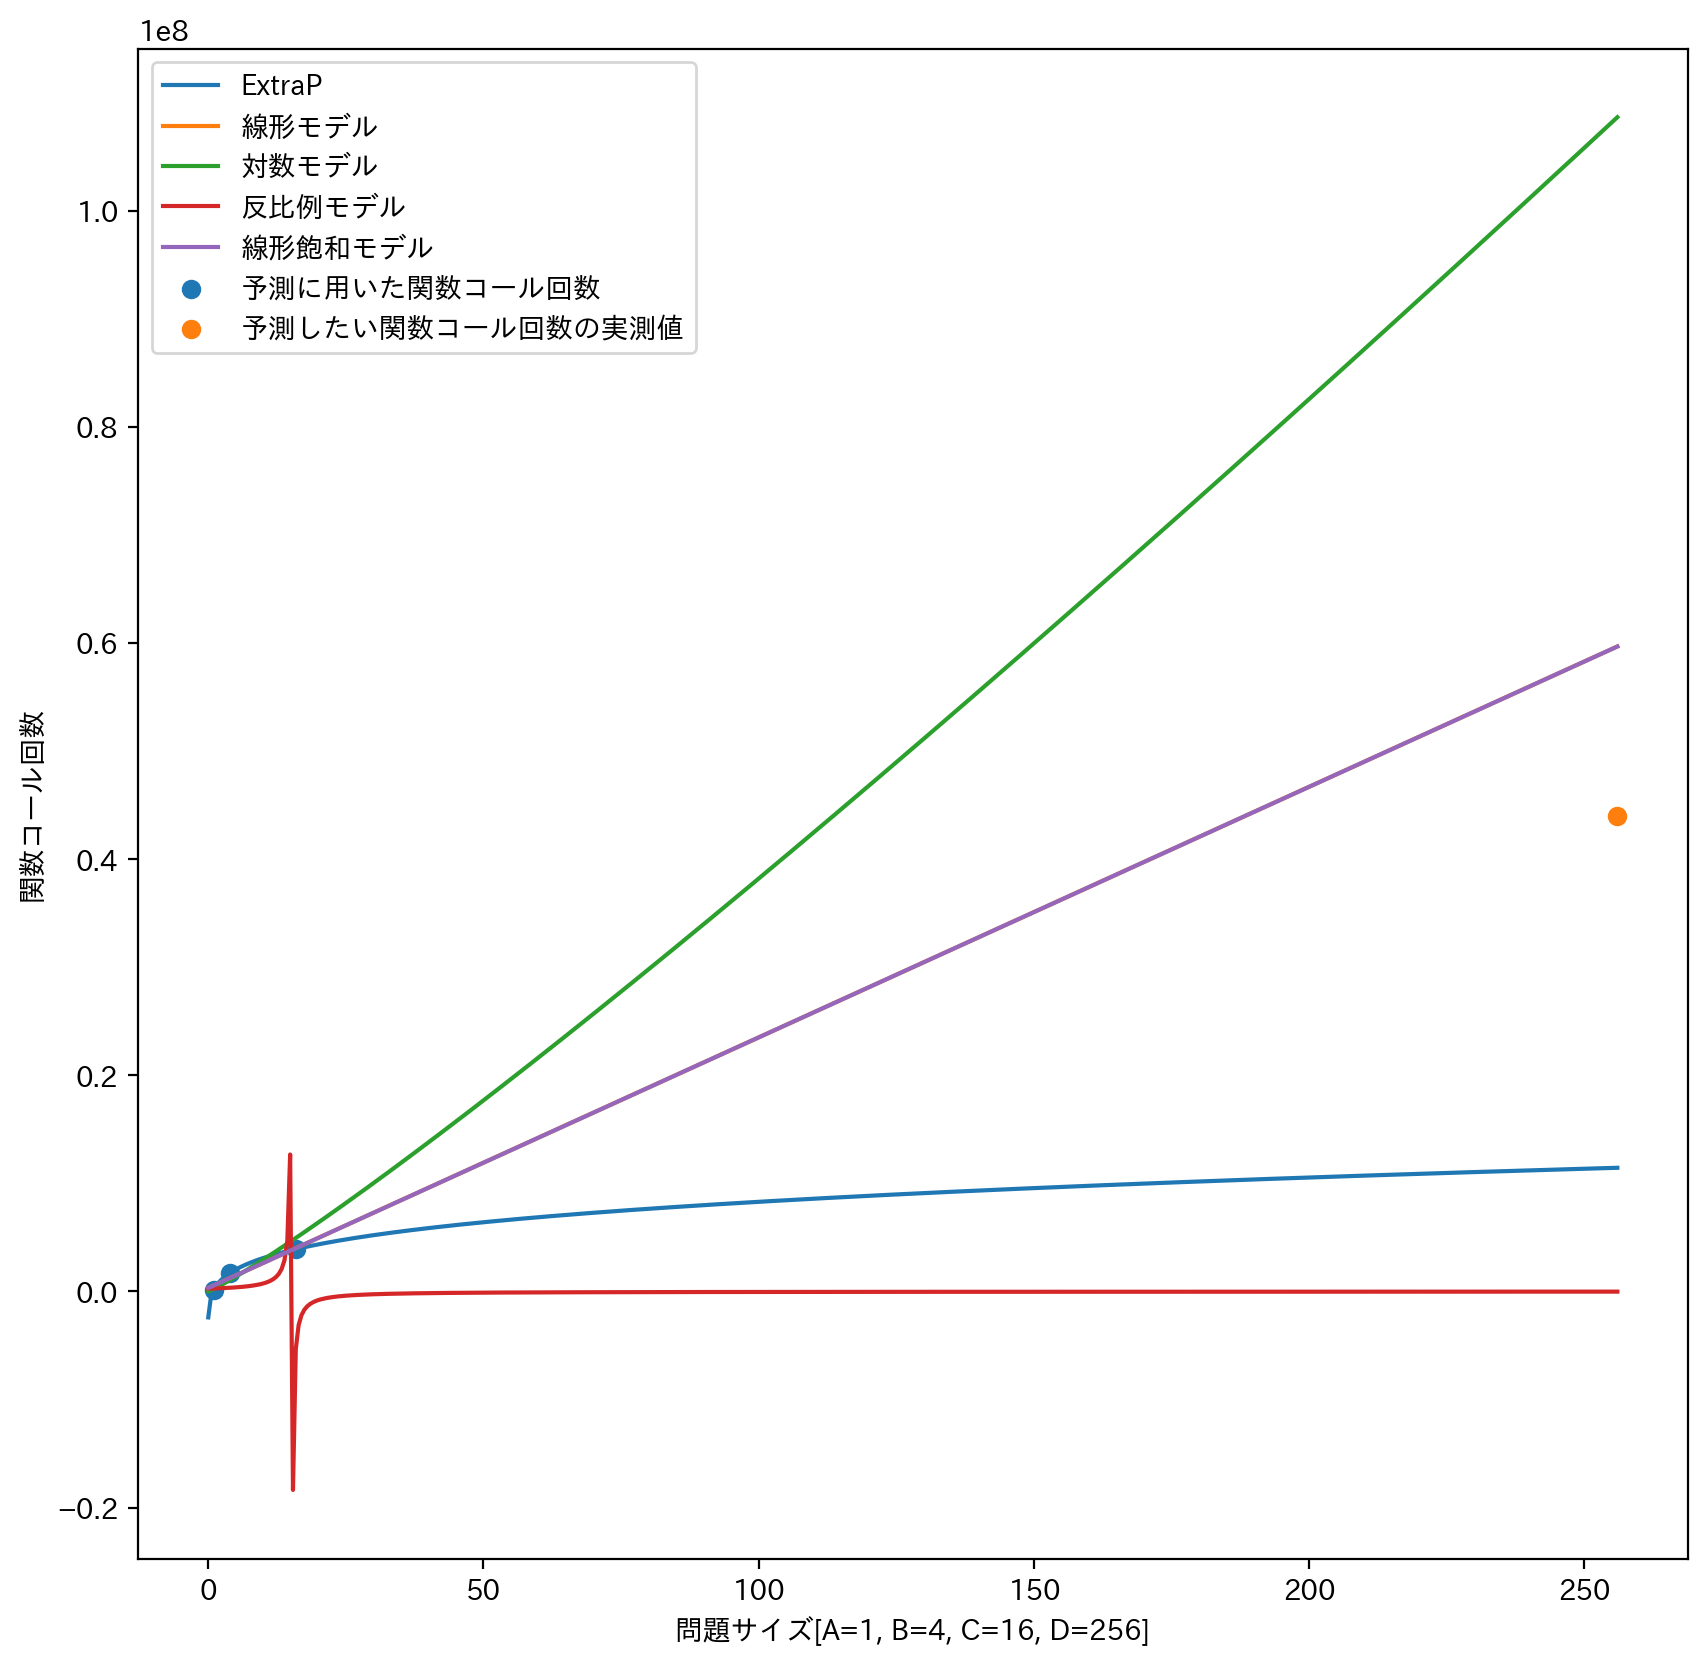

In [5]:
plt.figure(figsize=(10,10),dpi=200)

# Extra-PでfixProcessデータを入力して出力したモデルの図時
plot_x = np.linspace(0.01, 256, 500)
# -3590464.6990329633 + 3759195.349891038 * p^(1/4)
plot_y = []
for x in plot_x:
    plot_y.append(-3590464.6990329633 + 3759195.349891038 * x**(1/4))
plt.plot(plot_x, plot_y, label="ExtraP")

x = [1, 4, 16]
y = [180347, 1706010, 3936140]
x = np.array(x).reshape(-1,1)
y = np.array(y).reshape(-1,1)
plt.scatter(x, y, marker="o", label="予測に用いた関数コール回数")
plot_x = np.array(plot_x).reshape(-1, 1)
x_target = [256]
y_target = [44047200]
plt.scatter(x_target, y_target, marker="o", label="予測したい関数コール回数の実測値")

# 線形モデル
model_lin = ModelLin(x, y, "CG", "ICNVRT", test_ratio=0)
model_lin.calc_lr()
plot_y_lin = model_lin.predict(plot_x)
plt.plot(plot_x, plot_y_lin, label="線形モデル")
# logモデル
model_log10 = ModelLog10(x, y, "CG", "ICNVRT", test_ratio=0)
model_log10.calc_lr()
plot_y_log10 = model_log10.predict(plot_x)
plt.plot(plot_x, plot_y_log10, label="対数モデル")
# 反比例モデル
model_ip = ModelIP(x, y, "CG", "ICNVRT", test_ratio=0)
model_ip.calc_lr()
plot_y_ip = model_ip.predict(plot_x)
plt.plot(plot_x, plot_y_ip, label="反比例モデル")
# 線形飽和モデル
model_branch = ModelBranch(x, y, "CG", "ICNVRT", test_ratio=0)
model_branch.calc_lr()
plot_y_branch = model_branch.predict(plot_x)
plt.plot(plot_x, plot_y_branch, label="線形飽和モデル")
# 凡例の表示
plt.legend()
# 軸ラベルの設定
plt.ylabel("関数コール回数")
plt.xlabel("問題サイズ[A=1, B=4, C=16, D=256]")


<Figure size 2000x2000 with 0 Axes>

Text(0, 0.5, '関数コール回数')

Text(0.5, 0, '実行コア数')

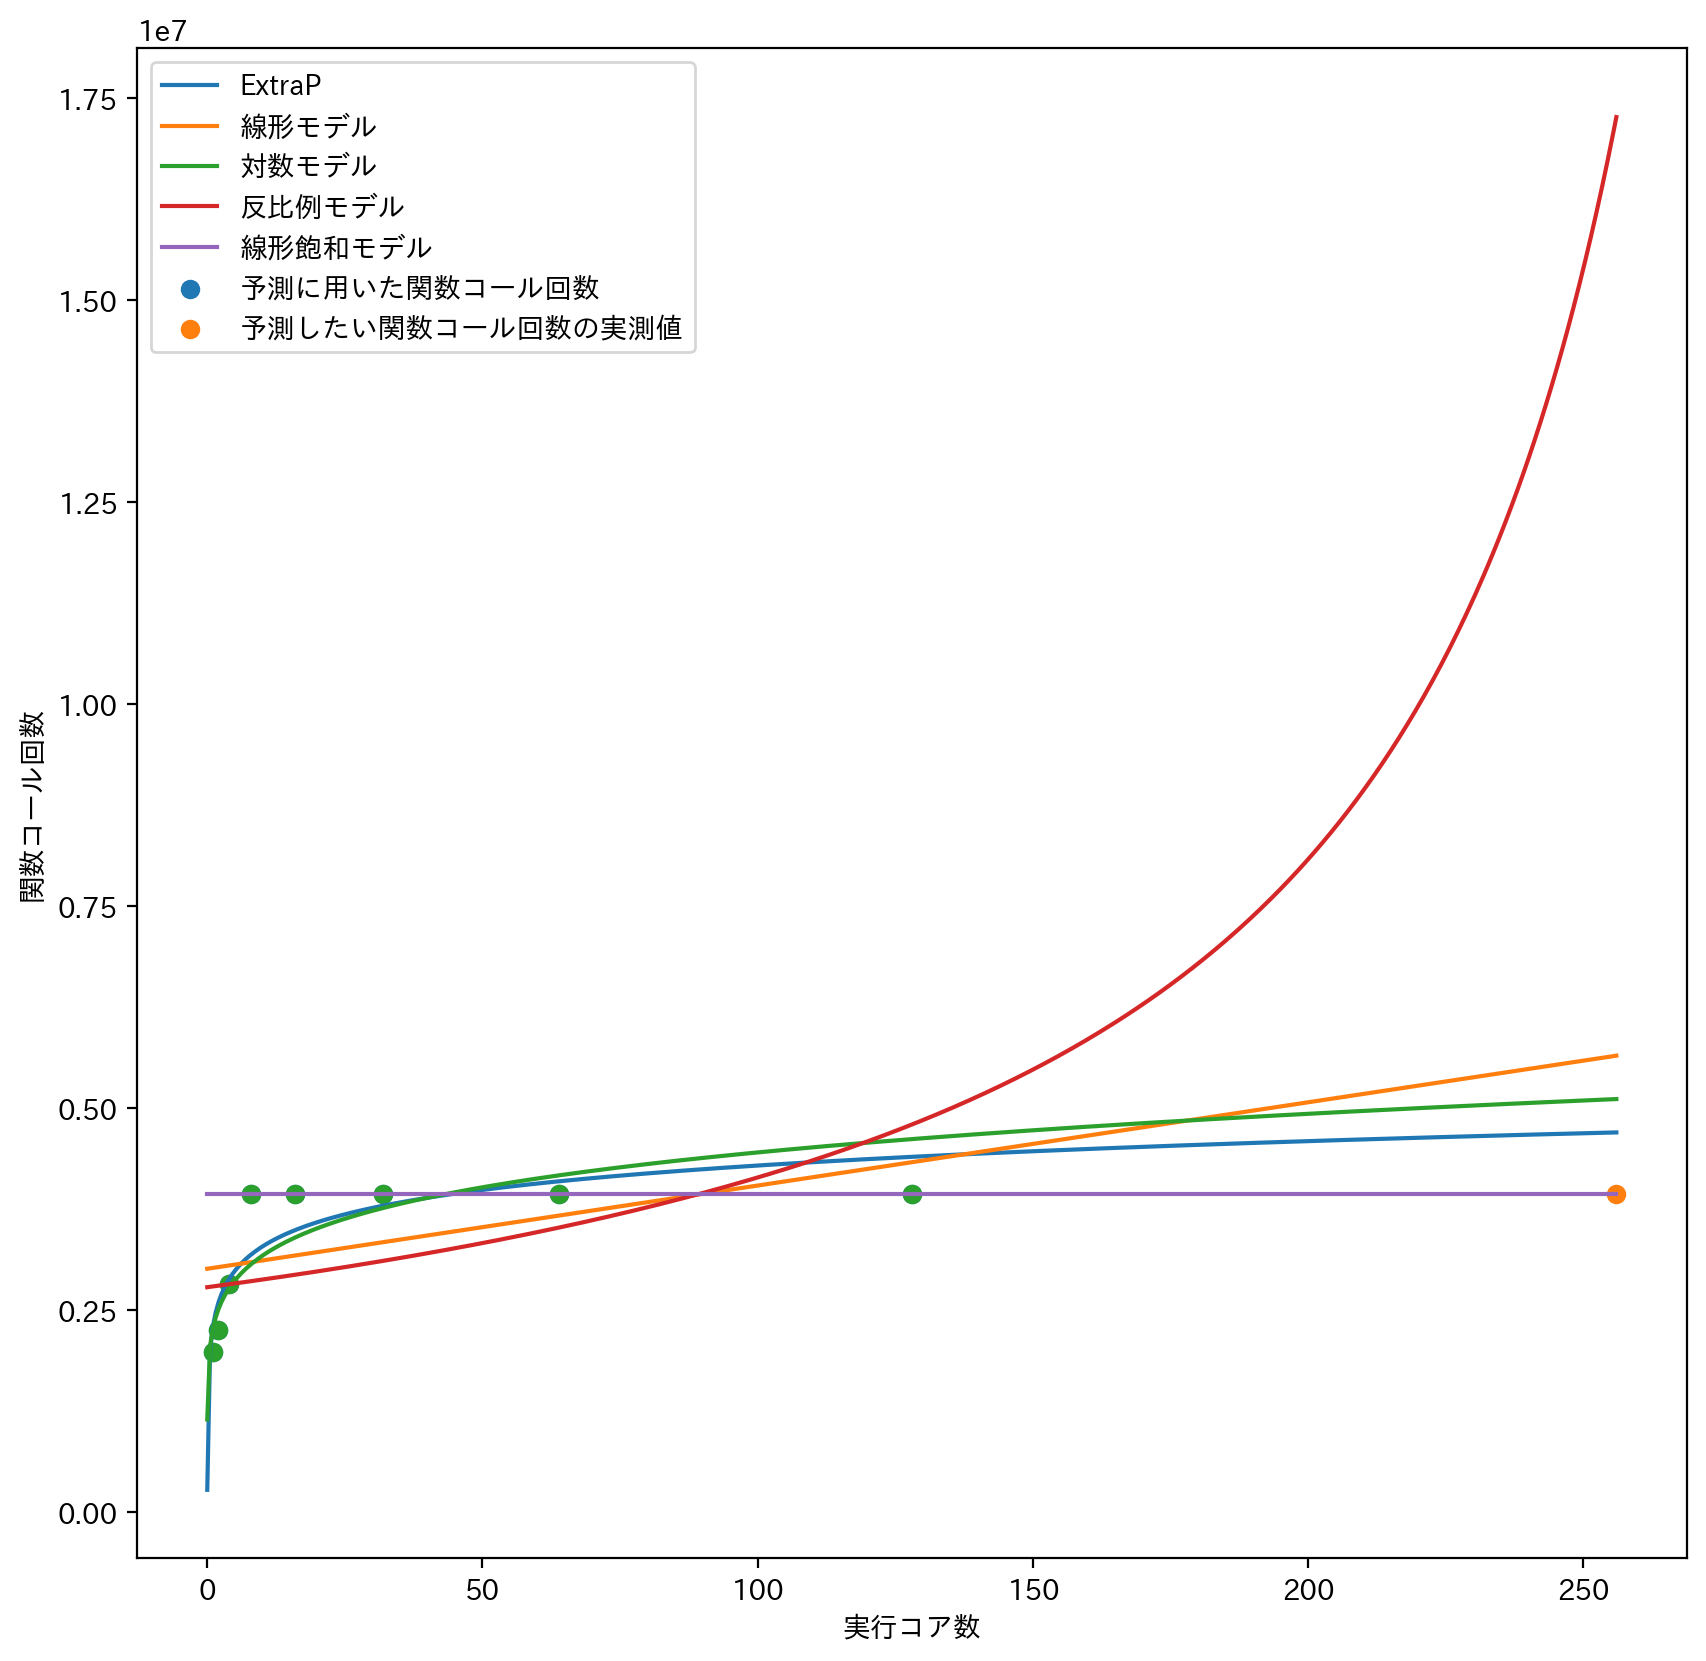

In [6]:
plt.figure(figsize=(10,10),dpi=200)

# Extra-PでfixProcessデータを入力して出力したモデルの図時
plot_x = np.linspace(0.01, 256, 500)
# -3590464.6990329633 + 3759195.349891038 * p^(1/4)
plot_y = []
for x in plot_x:
    plot_y.append(2286768.3333333326 + 301997.61904761934 * math.log2(x)**(1))
plt.plot(plot_x, plot_y, label="ExtraP")

x = [1, 2, 4, 8, 16, 32, 64, 128]
y = [1984770.0, 2263540.0, 2821070.0, 3936140.0, 3936140.0, 3936140.0, 3936140.0, 3936140.0]
x = np.array(x).reshape(-1,1)
y = np.array(y).reshape(-1, 1)
plt.scatter(x, y, marker="o", label="予測に用いた関数コール回数")
plot_x = np.array(plot_x).reshape(-1, 1)
x_target = [256]
y_target = [3936140]
plt.scatter(x_target, y_target, marker="o", label="予測したい関数コール回数の実測値")

# 線形モデル
model_lin = ModelLin(x, y, "CG", "ICNVRT", test_ratio=0)
model_lin.calc_lr()
plot_y_lin = model_lin.predict(plot_x)
plt.plot(plot_x, plot_y_lin, label="線形モデル")
# 対数モデル
model_log10 = ModelLog10(x, y, "CG", "ICNVRT", test_ratio=0)
model_log10.calc_lr()
plot_y_log10 = model_log10.predict(plot_x)
plt.plot(plot_x, plot_y_log10, label="対数モデル")
# 反比例モデル
model_ip = ModelIP(x, y, "CG", "ICNVRT", test_ratio=0)
model_ip.calc_lr()
plot_y_ip = model_ip.predict(plot_x)
plt.plot(plot_x, plot_y_ip, label="反比例モデル")
# 線形飽和モデル
model_branch = ModelBranch(x, y, "CG", "ICNVRT", test_ratio=0)
model_branch.calc_lr()
plot_y_branch = model_branch.predict(plot_x)
plt.plot(plot_x, plot_y_branch, label="線形飽和モデル")
# 凡例の表示
plt.legend()
# 軸ラベルの設定
plt.ylabel("関数コール回数")
plt.xlabel("実行コア数")

plt.scatter(x, y, marker="o")

In [7]:
FixedProcessDict = {}
for benchmark in benchmarks:
    targetDF = return_ErrorRateFixedProcessDF(benchmark=benchmark, FixProcess=64, predict_class="D")
    columns = targetDF.columns.tolist()
    # データ数4の予測精度よりデータ数3の予測精度のほうが高いものを抽出
    targetDF = targetDF[targetDF[columns[0]] > targetDF[columns[1]] ]
    # データが同じことに由来する重複を削除
    targetDF = targetDF[~targetDF.duplicated()]
    targetFunctionNameList = targetDF.index.tolist()
    FixedProcessDict[benchmark] = targetFunctionNameList
FixedProcessDict

{'bt': ['LHSABINIT', 'MPI_Irecv()', 'MPI_Wait()'],
 'cg': ['CONJ_GRAD', 'MPI_Irecv()'],
 'ep': [],
 'ft': ['CHECKSUM'],
 'is': [],
 'lu': ['EXACT'],
 'mg': ['GIVE3_EX'],
 'sp': ['LHSX', 'MPI_Irecv()', 'MPI_Waitall()']}

In [8]:
funcCallNumDict = {}
for benchmarkName in FixedProcessDict:
    print(f"-----{benchmarkName}-----")
    funcCallNumDict[benchmarkName] = {}
    for functionName in FixedProcessDict[benchmarkName]:
        funcCallNumDict[benchmarkName][functionName] = returnRawDF(Benchmark = benchmarkName, functionName = functionName, fix="Process", benchmarkClass = ["A", "B", "C", "D"], FixedProcess = 64)
        funcCallNumDict[benchmarkName][functionName]

-----bt-----


,A,B,C,D
Name,,,,
LHSABINIT,4824.0,4824.0,4824.0,6024.0


,A,B,C,D
Name,,,,
MPI_Irecv(),9654.0,9654.0,9654.0,12054.0


,A,B,C,D
Name,,,,
MPI_Wait(),16884.0,16884.0,16884.0,21084.0


-----cg-----


,A,B,C,D
Name,,,,
CONJ_GRAD,16,76.0,76.0,101.0


,A,B,C,D
Name,,,,
MPI_Irecv(),4208,19988.0,19988.0,26563.0


-----ep-----
-----ft-----


,A,B,C,D
Name,,,,
CHECKSUM,6.0,20.0,20.0,25.0


-----is-----
-----lu-----


,A,B,C,D
Name,,,,
EXACT,49178.4,205076.0,836921.0,13625000.0


-----mg-----


,A,B,C,D
Name,,,,
GIVE3_EX,15.0,63.0,63.0,153.0


-----sp-----


,A,B,C,D
Name,,,,
LHSX,3208.0,3208.0,3208.0,4008.0


,A,B,C,D
Name,,,,
MPI_Irecv(),19254.0,19254.0,19254.0,24054.0


,A,B,C,D
Name,,,,
MPI_Waitall(),17244.0,17244.0,17244.0,21544.0


In [9]:
FixedClassDict = {}
for benchmark in benchmarks:
    targetDF = return_ErrorRateFixedClassDF(benchmark=benchmark, FixClass="B", predict_process=256)
    columns = targetDF.columns.tolist()
    # 平均絶対誤差率が0.1より大きいものを抽出
    targetDF = targetDF[targetDF[columns[0]] > 0.1]
    # データが同じことに由来する重複を削除
    targetDF = targetDF[~targetDF.duplicated()]
    targetFunctionNameList = targetDF.index.tolist()
    FixedClassDict[benchmark] = targetFunctionNameList
FixedClassDict

{'bt': ['EXACT_SOLUTION'],
 'cg': ['MPI_Irecv()'],
 'ep': [],
 'ft': ['CFFTZ', 'FFTZ2', 'SET_CLASS'],
 'is': ['MPI_Irecv()', 'double_randlc(double_*_double_*)'],
 'lu': ['BLTS', 'EXCHANGE_6'],
 'mg': ['BUBBLE', 'ZERO3'],
 'sp': ['EXACT_SOLUTION']}

In [10]:
funcCallNumDict = {}
for benchmarkName in FixedClassDict:
    print(f"-----{benchmarkName}-----")
    if benchmarkName == "bt" or benchmarkName == "sp" :
        _processes = process_onlyBTSP
    else:
        _processes = process_excludeBTSP
    funcCallNumDict[benchmarkName] = {}
    for functionName in FixedClassDict[benchmarkName]:
        funcCallNumDict[benchmarkName][functionName] = returnRawDF(Benchmark = benchmarkName, functionName = functionName, fix="Class", Processes = _processes, FixedBenchmarkClass="B")
        funcCallNumDict[benchmarkName][functionName]

-----bt-----


,1,4,16,64,256
Name,,,,,
EXACT_SOLUTION,16980600.0,4275140.0,1083780.0,278446.0,73361.5


-----cg-----


,1,2,4,8,16,32,64,128,256
Name,,,,,,,,,
MPI_Irecv(),2576.0,4203,5462,13984.0,13984.0,19988.0,19988.0,25992.0,25992.0


-----ep-----
-----ft-----


,1,2,4,8,16,32,64,128,256
Name,,,,,,,,,
CFFTZ,2048.0,225280.0,112640.0,56320.0,28160.0,14080.0,7040.0,3520.0,1760.0


,1,2,4,8,16,32,64,128,256
Name,,,,,,,,,
FFTZ2,15360.0,1847300.0,923648.0,461824.0,230912.0,115456.0,57728.0,28864.0,14432.0


,1,2,4,8,16,32,64,128,256
Name,,,,,,,,,
SET_CLASS,0.003906,0.5,0.25,0.125,0.0625,0.03125,0.015625,0.007812,0.003906


-----is-----


,1,2,4,8,16,32,64,128,256
Name,,,,,,,,,
MPI_Irecv(),0.996094,0.5,0.75,0.875,0.9375,0.96875,0.984375,0.992188,0.996094


,1,2,4,8,16,32,64,128,256
Name,,,,,,,,,
double_randlc(double_*_double_*),131099.0,67108900.0,33554500.0,16777200.0,8388640.0,4194330.0,2097180.0,1048600.0,524317.0


-----lu-----


,1,2,4,8,16,32,64,128,256
Name,,,,,,,,,
BLTS,2510000.0,2510000.0,1255000.0,1255000.0,627500.0,627500.0,313750.0,313750.0,156875.0


,1,2,4,8,16,32,64,128,256
Name,,,,,,,,,
EXCHANGE_6,2.0,1.0,1.0,0.5,0.5,0.25,0.25,0.125,0.125


-----mg-----


,1,2,4,8,16,32,64,128,256
Name,,,,,,,,,
BUBBLE,608.0,575.0,542.0,525.25,499.5,468.125,444.219,415.953,390.875


,1,2,4,8,16,32,64,128,256
Name,,,,,,,,,
ZERO3,151.0,151.0,151.0,151.0,172.0,182.5,187.75,221.875,238.938


-----sp-----


,1,4,16,64,256
Name,,,,,
EXACT_SOLUTION,16980600.0,4275140.0,1083780.0,278446.0,73361.5


In [11]:
sampleDF = returnRawDF(fix="Class")
sampleDF
sampleDF.to_json(orient='records', force_ascii=False, lines = True)

,1,2,4,8,16,32,64,128,256
Name,,,,,,,,,
.TAU_application,1.0,1,1,1.0,1.0,1.0,1.0,1.0,1.0


'{"1":1.0,"2":1,"4":1,"8":1.0,"16":1.0,"32":1.0,"64":1.0,"128":1.0,"256":1.0}\n'

In [18]:
# 引数：sampleDFには returnRawDF() の返値

# def returnDFforExtraPinput(sampleDF):
    
# explanatoryVariableList は説明変数(コア数もしくは問題サイズ)のリスト
explanatoryVariableList = sampleDF.columns.tolist()
# explanatoryVariableList
# functionName は関数名のリスト(要素は1つのはず)
functionName = sampleDF.index.tolist()
# functionName
# repeated は重複させる数(ExtraPは同じ条件で複数回の元データを必要とする)
repeated = 5
# params は後に返すDFのparamsカラムに相当するリスト
params = []
for param in explanatoryVariableList:
    params += [(f"{{'x':{param}}}")]*repeated
# params
# metric は後に返すDFのmetricカラムに相当するリスト
metric = []
for _column in explanatoryVariableList:
    metric += [functionName] * repeated
# metric
# value は後に返すDFのvalueカラムに相当するリスト
value = []
for _column in explanatoryVariableList:
    for _functionName in functionName:
        value += [float(sampleDF.at[_functionName, _column])]*repeated
# value

returnDF = pd.DataFrame([params, metric, value]).T
columns = ["params", "metric", "value"]
returnDF.columns = columns
print(returnDF.to_json(orient='records', force_ascii=False, lines=True))


{"params":"{'x':1}","metric":[".TAU_application"],"value":1.0}
{"params":"{'x':1}","metric":[".TAU_application"],"value":1.0}
{"params":"{'x':1}","metric":[".TAU_application"],"value":1.0}
{"params":"{'x':1}","metric":[".TAU_application"],"value":1.0}
{"params":"{'x':1}","metric":[".TAU_application"],"value":1.0}
{"params":"{'x':2}","metric":[".TAU_application"],"value":1.0}
{"params":"{'x':2}","metric":[".TAU_application"],"value":1.0}
{"params":"{'x':2}","metric":[".TAU_application"],"value":1.0}
{"params":"{'x':2}","metric":[".TAU_application"],"value":1.0}
{"params":"{'x':2}","metric":[".TAU_application"],"value":1.0}
{"params":"{'x':4}","metric":[".TAU_application"],"value":1.0}
{"params":"{'x':4}","metric":[".TAU_application"],"value":1.0}
{"params":"{'x':4}","metric":[".TAU_application"],"value":1.0}
{"params":"{'x':4}","metric":[".TAU_application"],"value":1.0}
{"params":"{'x':4}","metric":[".TAU_application"],"value":1.0}
{"params":"{'x':8}","metric":[".TAU_application"],"valu